In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline

## Baum-Welch Algorithm Implemenation

### Normalized Forward Algorithm Normalization Calculation

In [2]:
def alpha_ct_calc(x,c_t,t,observations,a_matrix,b_matrix,big_t):
    if t==big_t:
        return c_t
    else:
        t = t + 1
        temp1 = np.asarray(x*a_matrix)[0]
        #print(temp1)
        temp2 = np.asarray(b_matrix[observations[t],:])[0]
        #print(temp2)
        x= temp1*temp2
        c = sum(x)
        c_t.append(c)
        x = x/c
        return alpha_ct_calc(x,c_t,t,observations,a_matrix,b_matrix,big_t)

### Normalized Forward Algorithm

In [3]:
def alpha_var(x,c_t,t,observations,a_matrix,b_matrix,big_t):
    if t==big_t:
        #print(x)
        return(x)
    else:
        t = t + 1
        temp1 = np.asarray(x*a_matrix)[0]
        temp2 = np.asarray(b_matrix[observations[t],:])[0]
        x= temp1*temp2
        x = x/c_t[t]
        return alpha_var(x,c_t,t,observations,a_matrix,b_matrix,big_t)

### Normalized Backward Algorithm

In [4]:
def beta_var(x,c_t,t,observations,a_matrix,b_matrix,small_t):
    if t==small_t:
        return(x) 
    else:
        t = t - 1
        x_new = np.zeros(len(x))
        for i in range(0,len(x)):
            temp1 = np.asarray(a_matrix[i,:])[0]
            #print(temp1)
            temp2 = np.asarray(b_matrix[observations[t+1],:])[0]
            #print(temp2)
            temp3 = temp1*temp2*x
            #print(temp3)
            x_new[i] = sum(temp3)
        x_new = x_new/c_t[t]
        return beta_var(x_new,c_t,t,observations,a_matrix,b_matrix,small_t)

### Gamma Calculation

In [5]:
def gamma_vec(alpha,beta):
    gamma = (alpha*beta)/sum(alpha*beta)
    return(gamma)

### Xi Calculation

In [6]:
def xi_matrix(alpha,beta,a_matrix,b_matrix,observation):
    xi_matrix = np.empty([a_matrix.shape[0],a_matrix.shape[1]])
    denominator = 0
    
    for k in range(0,a_matrix.shape[0]):
        for l in range(0,a_matrix.shape[1]):
            denominator = denominator + alpha[k]*a_matrix[k,l]*b_matrix[observation,l]*beta[l]

    for i in range(0,a_matrix.shape[0]):
        for j in range(0,a_matrix.shape[0]):
            numerator = alpha[i]*a_matrix[i,j]*b_matrix[observation,j]*beta[j]
            xi_matrix[i,j] = numerator/denominator
            
    return(xi_matrix)

### Baum Welch Implementation

In [7]:
def bw_algo(observations,pi_vector,a_matrix,b_matrix,alphabet,iterations):
    
    for update in range(0,iterations):
        print("==========================================")
        print("Iteration #:" + str(update))

        #generic initializations
        big_t = len(observations)
        
        gamma = np.zeros([big_t,pi_vector.shape[0]])
        xi = np.zeros([big_t,a_matrix.shape[0],a_matrix.shape[1]])
        
        c_t = []
        
        alpha_1 = pi_vector*np.asarray(b_matrix[observations[0],:])
        if(alpha_1.shape[0] == 1):
            alpha_1 = alpha_1[0]
        c = sum(alpha_1)
        alpha_1 = alpha_1/c
        c_t.append(c)
        
        alpha_ct = []
        alpha_ct = alpha_ct_calc(alpha_1,c_t,0,observations,a_matrix,b_matrix,big_t-1)

        beta_1 = np.ones(pi_vector.shape[0])
        gamma = gamma_vec(alpha_1,beta_1)
        
        beta_t_plus_1 = np.ones(pi_vector.shape[0])
        beta_t_plus_1 = beta_var(beta_1,alpha_ct,big_t-1,observations,a_matrix,b_matrix,1)

        xi = xi_matrix(alpha_1,beta_t_plus_1,a_matrix,b_matrix,observations[1])

        a_matrix_new = np.zeros([a_matrix.shape[0],a_matrix.shape[1]])
        
        #for a matrix(transition probabilities matrix)
        for t in range(1,big_t-2):
            alpha_t = alpha_var(alpha_1,alpha_ct,0,observations,a_matrix,b_matrix,t)
            beta_t = beta_var(beta_1,alpha_ct,big_t-1,observations,a_matrix,b_matrix,t-1)
            beta_t_plus_1 = beta_var(beta_1,alpha_ct,big_t-1,observations,a_matrix,b_matrix,t)
            gamma = gamma + gamma_vec(alpha_t,beta_t)
            xi = xi + xi_matrix(alpha_t,beta_t_plus_1,a_matrix,b_matrix,observations[t+1])

        for i in range(0,a_matrix.shape[0]):
            for j in range(0,a_matrix.shape[1]):
                a_matrix_new[i,j] = xi[i,j]/gamma[i]
                
                
        #for b matrix(emission prob matrix) updates
        b_matrix_new = np.zeros([b_matrix.shape[0],b_matrix.shape[1]])
        
        for m in range(0,len(alphabet)):
            gamma = gamma_vec(alpha_1,beta_1)
            #t=0 calculations happen here
            if(observations[t] == alphabet[m]):
                num_vec = gamma
            else:
                num_vec = np.zeros([a_matrix.shape[0]])
                
            denom_vec = gamma 
            
            #for loop starts from t=1->T
            for t in range(1,big_t-1):
                alpha_t = alpha_var(alpha_1,alpha_ct,0,observations,a_matrix,b_matrix,t)
                beta_t = beta_var(beta_1,alpha_ct,big_t-1,observations,a_matrix,b_matrix,t-1)
                gamma = gamma_vec(alpha_t,beta_t)
                denom_vec = denom_vec + gamma
                if(observations[t] == alphabet[m]):
                    num_vec = num_vec + gamma
               
            result_vec = num_vec/denom_vec
            
            for j in range(0,b_matrix.shape[1]):
                b_matrix_new[m,j] = result_vec[j]
        
        new_pi_vector = gamma_vec(alpha_1,beta_1)
        
        a_matrix = np.asmatrix(a_matrix_new)
        b_matrix = np.asmatrix(b_matrix_new)
        pi_vector = np.asarray(new_pi_vector)
        
        print("a_matrix: ")
        print(a_matrix)
        print("b_matrix: ")
        print(b_matrix)
        print("pi_vector: ")
        print(pi_vector)
    return(a_matrix,b_matrix,pi_vector)

## Viterbi Algorithm

In [8]:
def viterbi(v,seq,a_matrix,b_matrix,observations,t,big_t):
    if(t == big_t):
        return(max(v[t]),np.argmax(v[t]))
    else:
        t= t+1
        v_temp = np.zeros(v.shape[1])
        seq_temp = np.zeros(seq.shape[1])
        
        for j in range(0,a_matrix.shape[1]):
            v_temp[j] = v[t-1,0]*a_matrix[0,j]*b_matrix[observations[t],j]
            seq_temp[j] = 0
            for i in range(0,a_matrix.shape[0]):
                temp_var = (v[t-1,i]*a_matrix[i,j]*b_matrix[observations[t],j])
                if(temp_var > v_temp[j]):
                    v_temp[j] = temp_var
                    seq_temp[j] = i
                    
        #v_temp =v_temp/sum(v_temp)
        v[t] = v_temp
        seq[t] = seq_temp
        print(v[t])
        print(seq[t])
        return viterbi(v,seq,a_matrix,b_matrix,observations,t,big_t)

## Exploratory Data Analysis 

In [9]:
data_set_1 = pd.read_csv('datatraining.csv')

### Discretizing Attributes

In [10]:
new_data = []
for data in data_set_1['Light']:
    val = data
    if val == 0:
        new_data.append(0)
    elif val > 0:
        new_data.append(1)

data_set_1['Light_Level'] = pd.DataFrame(new_data)

In [11]:
new_data = []
for data in data_set_1['CO2']:
    val = data
    if (val > 400.00) & (val < 800.00):
        new_data.append(0)
    elif (val > 800) & (val < 1200):
        new_data.append(1)
    elif (val > 1200) & (val < 1600):
        new_data.append(2)
    elif (val > 1600):
        new_data.append(3)

data_set_1['CO2_Level'] = pd.DataFrame(new_data)

In [12]:
data_set_1.head()

date  Temperature  Humidity  Light     CO2  HumidityRatio  \
1  2015-02-04 17:51:00        23.18   27.2720  426.0  721.25       0.004793   
2  2015-02-04 17:51:59        23.15   27.2675  429.5  714.00       0.004783   
3  2015-02-04 17:53:00        23.15   27.2450  426.0  713.50       0.004779   
4  2015-02-04 17:54:00        23.15   27.2000  426.0  708.25       0.004772   
5  2015-02-04 17:55:00        23.10   27.2000  426.0  704.50       0.004757   

   Occupancy  Light_Level  CO2_Level  
1          1          1.0        0.0  
2          1          1.0        0.0  
3          1          1.0        0.0  
4          1          1.0        0.0  
5          1          1.0        0.0

Text(0,0.5,'CO2 Reading')

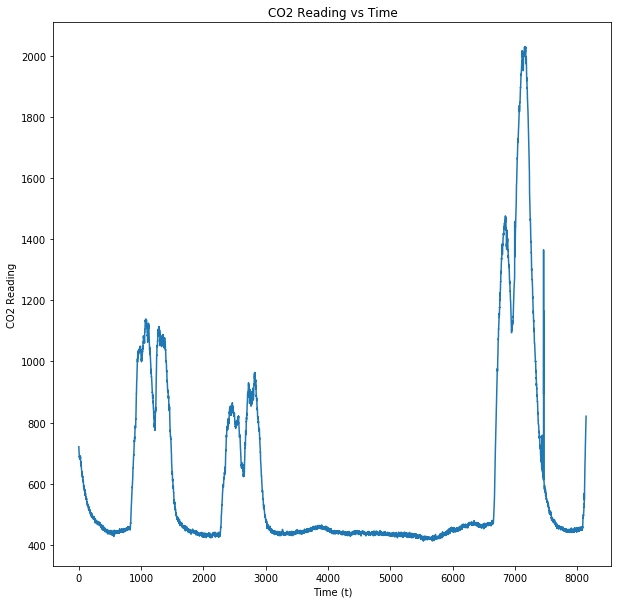

In [13]:
ax = data_set_1['CO2'].plot(figsize=(10,10),title='CO2 Reading vs Time')
ax.set_xlabel("Time (t)")
ax.set_ylabel("CO2 Reading")

Text(0,0.5,'CO2 Level')

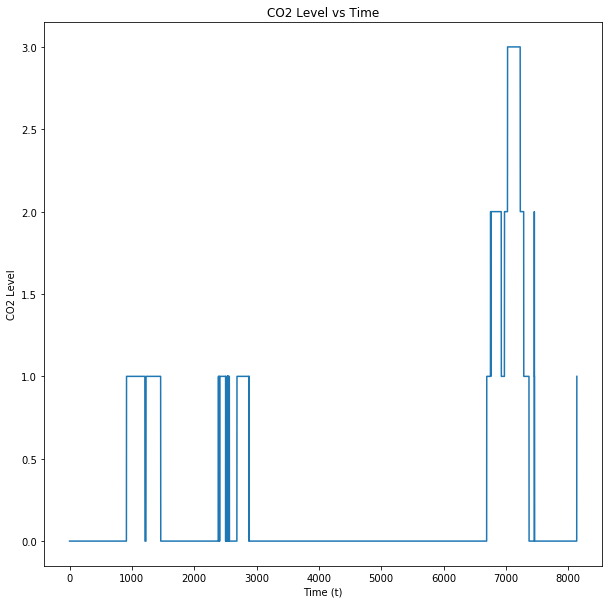

In [14]:
ax = data_set_1['CO2_Level'].plot(figsize=(10,10),title='CO2 Level vs Time')
ax.set_xlabel("Time (t)")
ax.set_ylabel("CO2 Level")

Text(0,0.5,'Light Reading')

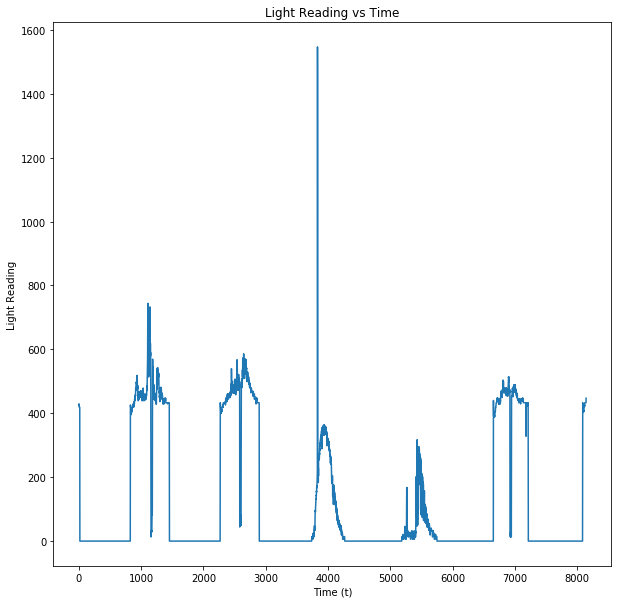

In [15]:
ax = data_set_1['Light'].plot(figsize=(10,10),title='Light Reading vs Time')
ax.set_xlabel("Time (t)")
ax.set_ylabel("Light Reading")

Text(0,0.5,'Light Level')

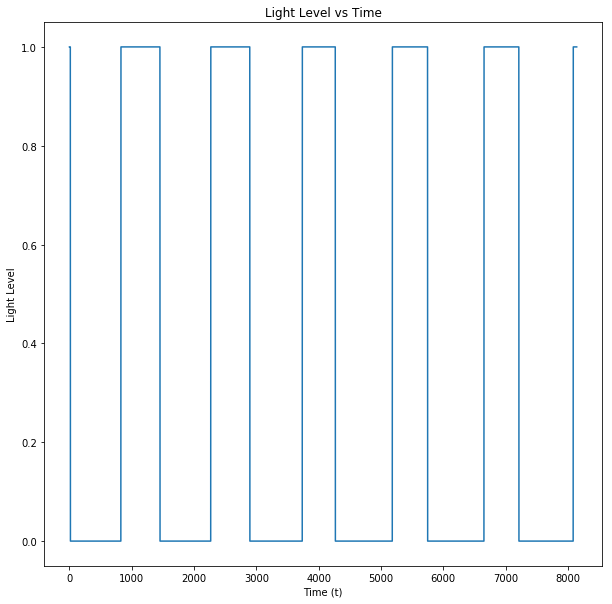

In [16]:
ax = data_set_1['Light_Level'].plot(figsize=(10,10),title='Light Level vs Time')
ax.set_xlabel("Time (t)")
ax.set_ylabel("Light Level")

Text(0,0.5,'Occupancy')

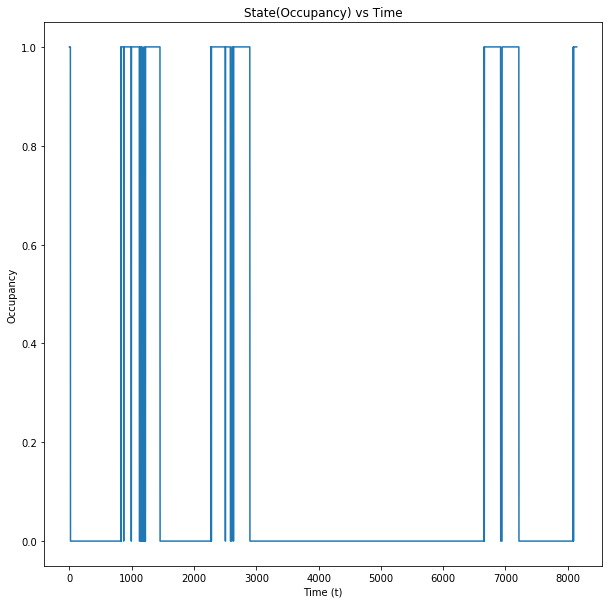

In [17]:
ax = data_set_1['Occupancy'].plot(figsize=(10,10),title='State(Occupancy) vs Time')
ax.set_xlabel("Time (t)")
ax.set_ylabel("Occupancy")

In [18]:
data_set_1[['CO2']].describe()

CO2
count  8143.000000
mean    606.546243
std     314.320877
min     412.750000
25%     439.000000
50%     453.500000
75%     638.833333
max    2028.500000

In [19]:
print("Mean: " + str(data_set_1['CO2'].mean()))
print("Median: " + str(data_set_1['CO2'].median()))
print("Variance: " + str(data_set_1['CO2'].var()))

Mean: 606.546243195
Median: 453.5
Variance: 98797.6136433


In [20]:
data_set_1[['Light']].describe()

Light
count  8143.000000
mean    119.519375
std     194.755805
min       0.000000
25%       0.000000
50%       0.000000
75%     256.375000
max    1546.333333

In [21]:
print("Mean: " + str(data_set_1['Light'].mean()))
print("Median: " + str(data_set_1['Light'].median()))
print("Variance: " + str(data_set_1['Light'].var()))

Mean: 119.519374514
Median: 0.0
Variance: 37929.8235028


# CO2

In [48]:
a_matrix = np.matrix([[0.5,0.5],
                      [0.6,0.4]])
b_matrix = np.matrix([[0.2,0.1],
                      [0.3,0.5],
                      [0.2,0.3],
                      [0.3,0.2]])
pi_vector = np.array([0.2,0.8])

delta_t = 100
alphabet = [0,1,2,3]
observations = data_set_1[pd.notnull(data_set_1['CO2_Level'])]['CO2_Level'].tolist()
observations = [int(x) for x in observations]
observations = observations[0:len(observations):delta_t]

new_a_matrix, new_b_matrix, new_pi = bw_algo(observations,pi_vector,a_matrix,b_matrix,alphabet,20)

Iteration #:0
a_matrix: 
[[ 0.61322376  0.38615594]
 [ 0.68205793  0.3190169 ]]
b_matrix: 
[[ 0.8558857   0.70968083]
 [ 0.09235772  0.21126904]
 [ 0.0271304   0.05424556]
 [ 0.02462618  0.02480457]]
pi_vector: 
[ 0.33333333  0.66666667]
Iteration #:1
a_matrix: 
[[ 0.61924129  0.38047843]
 [ 0.67025546  0.3302304 ]]
b_matrix: 
[[ 0.84874958  0.7220675 ]
 [ 0.0975571   0.20224499]
 [ 0.02876281  0.0514116 ]
 [ 0.0249305   0.02427591]]
pi_vector: 
[ 0.37617259  0.62382741]
Iteration #:2
a_matrix: 
[[ 0.62379957  0.37602247]
 [ 0.661308    0.33900068]]
b_matrix: 
[[ 0.84382231  0.7305985 ]
 [ 0.10118675  0.1959636 ]
 [ 0.02985447  0.04952013]
 [ 0.02513647  0.02391777]]
pi_vector: 
[ 0.41479444  0.58520556]
Iteration #:3
a_matrix: 
[[ 0.62747004  0.37241471]
 [ 0.65393863  0.34626136]]
b_matrix: 
[[ 0.84035543  0.73660354]
 [ 0.10375798  0.19151205]
 [ 0.03060309  0.0482225 ]
 [ 0.0252835   0.02366192]]
pi_vector: 
[ 0.4501407  0.5498593]
Iteration #:4
a_matrix: 
[[ 0.63057835  0.36934831

In [49]:
v_matrix = np.zeros([len(observations),len(new_pi)])
seq_matrix = np.zeros([len(observations),len(new_pi)])
v1 = pi_vector*np.asarray(new_b_matrix[observations[0],:])[0]
#v1 = v1/sum(v1)
seq1 = np.zeros(len(new_pi))
v_matrix[0] = v1
seq_matrix[0] = seq1
viterbi(v_matrix,seq_matrix,new_a_matrix,new_b_matrix,observations,0,len(observations)-1)

[ 0.18976339  0.14736701]
[ 1.  1.]
[ 0.13131368  0.04734167]
[ 0.  1.]
[ 0.09086727  0.01936499]
[ 0.  0.]
[ 0.06287891  0.01340031]
[ 0.  0.]
[ 0.04351135  0.00927283]
[ 0.  0.]
[ 0.03010926  0.00641667]
[ 0.  0.]
[ 0.0208352   0.00444025]
[ 0.  0.]
[ 0.01441767  0.00307259]
[ 0.  0.]
[ 0.00997683  0.00212619]
[ 0.  0.]
[ 0.00029077  0.00077987]
[ 0.  0.]
[  1.35874600e-05   1.32798485e-04]
[ 1.  1.]
[  2.31369693e-06   2.26131629e-05]
[ 1.  1.]
[  3.93980441e-07   3.85060972e-06]
[ 1.  1.]
[  6.70876922e-08   6.55688691e-07]
[ 1.  1.]
[  2.71239655e-07   2.10640079e-07]
[ 1.  1.]
[  1.87694140e-07   6.76681533e-08]
[ 0.  1.]
[  1.29881783e-07   2.76794906e-08]
[ 0.  0.]
[  8.98764214e-08   1.91538298e-08]
[ 0.  0.]
[  6.21932570e-08   1.32541888e-08]
[ 0.  0.]
[  4.30368851e-08   9.17171777e-09]
[ 0.  0.]
[  2.97809372e-08   6.34670353e-09]
[ 0.  0.]
[  2.06080021e-08   4.39183223e-09]
[ 0.  0.]
[  1.42604562e-08   3.03908797e-09]
[ 0.  0.]
[  4.15612700e-10   1.11471970e-09]
[ 0.  

(1.7258730573088994e-29, 0)

In [50]:
predicted_sequence = []
T = v_matrix.shape[0]-1
predicted_sequence.append(seq_matrix[T,np.argmax(np.argmax(v_matrix[T]))])
for i in range(v_matrix.shape[0]-2,-1,-1):
    predicted_sequence.append(seq_matrix[i,np.argmax(v_matrix[i+1])])

In [51]:
actual_sequence = data_set_1[pd.notnull(data_set_1['Occupancy'])]['Occupancy'].tolist()
actual_sequence = actual_sequence[0:len(actual_sequence):delta_t]

In [52]:
correct = 0
total = len(actual_sequence)
for i in range(0,len(actual_sequence)):
    difference = actual_sequence[i]-predicted_sequence[i]
    if difference == 0.0:
        correct = correct + 1
print(float(correct)/float(total))
    

0.756097560976


# Light Level

In [53]:
a_matrix = np.matrix([[0.5,0.5],
                      [0.6,0.4]])
b_matrix = np.matrix([[0.7,0.3],
                      [0.3,0.7]])
pi_vector = np.array([0.2,0.8])

delta_t = 100

alphabet = [0,1]
observations = data_set_1[pd.notnull(data_set_1['Light_Level'])]['Light_Level'].tolist()
observations = [int(x) for x in observations]
observations = observations[0:len(observations):delta_t]

new_a_matrix, new_b_matrix, new_pi = bw_algo(observations,pi_vector,a_matrix,b_matrix,alphabet,20)

Iteration #:0
a_matrix: 
[[ 0.5847757   0.41453916]
 [ 0.59171927  0.40922718]]
b_matrix: 
[[ 0.77236561  0.46070241]
 [ 0.22763439  0.53929759]]
pi_vector: 
[ 0.09677419  0.90322581]
Iteration #:1
a_matrix: 
[[ 0.61253273  0.38743975]
 [ 0.54825904  0.45177851]]
b_matrix: 
[[ 0.76653622  0.47090653]
 [ 0.23346378  0.52909347]]
pi_vector: 
[ 0.04326763  0.95673237]
Iteration #:2
a_matrix: 
[[ 0.63931658  0.36089281]
 [ 0.50539353  0.4943248 ]]
b_matrix: 
[[ 0.77476907  0.46211899]
 [ 0.22523093  0.53788101]]
pi_vector: 
[ 0.01956494  0.98043506]
Iteration #:3
a_matrix: 
[[ 0.67162502  0.32867904]
 [ 0.45419633  0.5454024 ]]
b_matrix: 
[[ 0.7990514   0.43302497]
 [ 0.2009486   0.56697503]]
pi_vector: 
[ 0.00828682  0.99171318]
Iteration #:4
a_matrix: 
[[ 0.71888017  0.28109677]
 [ 0.38442299  0.61560676]]
b_matrix: 
[[ 0.84682539  0.37504251]
 [ 0.15317461  0.62495749]]
pi_vector: 
[ 0.00295283  0.99704717]
Iteration #:5
a_matrix: 
[[ 0.7921692   0.2054127 ]
 [ 0.29215233  0.71097069]]


In [54]:
v_matrix = np.zeros([len(observations),len(new_pi)])
seq_matrix = np.zeros([len(observations),len(new_pi)])
v1 = pi_vector*np.asarray(new_b_matrix[observations[0],:])[0]
#v1 = v1/sum(v1)
seq1 = np.zeros(len(new_pi))
v_matrix[0] = v1
seq_matrix[0] = seq1
viterbi(v_matrix,seq_matrix,new_a_matrix,new_b_matrix,observations,0,len(observations)-1)

[ 0.15269592  0.02645903]
[ 1.  1.]
[ 0.13720078  0.00091427]
[ 0.  1.]
[ 0.12327805  0.00057527]
[ 0.  0.]
[ 0.11076815  0.0005169 ]
[ 0.  0.]
[ 0.09952772  0.00046444]
[ 0.  0.]
[ 0.08942794  0.00041731]
[ 0.  0.]
[ 0.08035305  0.00037497]
[ 0.  0.]
[ 0.07219905  0.00033692]
[ 0.  0.]
[  2.76568002e-15   6.76304319e-03]
[ 0.  0.]
[  5.74960691e-17   5.22078647e-03]
[ 1.  1.]
[  4.43845605e-17   4.03022879e-03]
[ 1.  1.]
[  3.42630243e-17   3.11116805e-03]
[ 1.  1.]
[  2.64496217e-17   2.40169161e-03]
[ 1.  1.]
[  2.04180016e-17   1.85400547e-03]
[ 1.  1.]
[  3.69713866e-04   6.40637272e-05]
[ 1.  1.]
[  3.32196378e-04   2.21367262e-06]
[ 0.  1.]
[  2.98486056e-04   1.39287762e-06]
[ 0.  0.]
[  2.68196559e-04   1.25153245e-06]
[ 0.  0.]
[  2.40980752e-04   1.12453058e-06]
[ 0.  0.]
[  2.16526726e-04   1.01041649e-06]
[ 0.  0.]
[  1.94554223e-04   9.07882359e-07]
[ 0.  0.]
[  1.74811426e-04   8.15753097e-07]
[ 0.  0.]
[  6.69638223e-18   1.63749682e-05]
[ 0.  0.]
[  1.39211931e-19   1.

(5.288437430871791e-16, 1)

In [55]:
predicted_sequence = []
T = v_matrix.shape[0]-1
predicted_sequence.append(seq_matrix[T,np.argmax(np.argmax(v_matrix[T]))])
for i in range(v_matrix.shape[0]-2,-1,-1):
    predicted_sequence.append(seq_matrix[i,np.argmax(v_matrix[i+1])])

In [56]:
actual_sequence = data_set_1[pd.notnull(data_set_1['Occupancy'])]['Occupancy'].tolist()
actual_sequence = actual_sequence[0:len(actual_sequence):delta_t]

In [57]:
correct = 0
total = len(actual_sequence)
for i in range(0,len(actual_sequence)):
    difference = actual_sequence[i]-predicted_sequence[i]
    if difference == 0.0:
        correct = correct + 1
print(float(correct)/float(total))

0.756097560976


# TEST DATA

In [ ]:
a_matrix = np.matrix([[0.4,0.3,0.3],[0.3,0.4,0.3],[0.3,0.3,0.4]])
b_matrix = np.matrix([[0.4,0.3,0.3],[0.3,0.4,0.3],[0.3,0.3,0.4]])
alphabet = [0,1,2]
observations = [0,0,0,0,0,1,1,1,1,0,1,2,1,1,2,1,1,0,0,0,0,0,0]
pi_vector = np.array([0.3,0.4,0.3])
new_a_matrix, new_b_matrix = bw_algo(observations,pi_vector,a_matrix,b_matrix,alphabet,5)

v_matrix = np.zeros([len(observations),len(pi_vector)])
seq_matrix = np.zeros([len(observations),len(pi_vector)])
v1 = pi_vector*np.asarray(b_matrix[observations[0],:])[0]
v1 = v1/sum(v1)
seq1 = np.zeros(len(pi_vector))
v_matrix[0] = v1
seq_matrix[0] = seq1
viterbi(v_matrix,seq_matrix,a_matrix,b_matrix,observations,0,len(observations)-1)

In [ ]:
predicted_sequence = []
for i in range(0,v_matrix.shape[0]):
    predicted_sequence.append(seq_matrix[i,np.argmax(v_matrix[i])])
predicted_sequence